In [19]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

In [20]:
#Checking wich GPU is beeing used

!nvidia-smi

Wed Nov 24 20:32:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   33C    P8    19W / 250W |   6034MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [21]:
#Load data
data_file_true = 'dialogue/Dataset/VoiceDetection/Big_dataset/Output_true.npy'
data_file_false = 'dialogue/Dataset/VoiceDetection/Big_dataset/Output_false.npy'

true_data = np.load(data_file_true, allow_pickle = True)
false_data = np.load(data_file_false, allow_pickle = True)
df_true_data = pd.DataFrame(true_data)
df_false_data = pd.DataFrame(false_data)

df_true_data['label'] = True
df_false_data['label'] = False
#print(data)

#df_data['data'] = df_temp.values.tolist()
df_data = pd.concat([df_true_data, df_false_data])
#print(df_data.head())
np_labels = df_data['label'].to_numpy()
np_data = df_data.drop(['label'],axis = 1).to_numpy()
print(df_data)
print(np_labels)

                0           1           2           3           4           5  \
0     -602.022766 -602.723755 -603.376587 -604.697205 -604.944519 -604.832581   
1     -184.963791 -167.952698 -158.673050 -179.185837 -206.072037 -246.351532   
2     -273.273712 -253.240891 -222.000061 -167.081268 -170.382721 -216.621155   
3     -612.132263 -605.841003 -601.784912 -606.503540 -611.724365 -615.397827   
4      -99.539803 -116.719917 -150.092438 -132.454346 -153.093674 -134.829453   
...           ...         ...         ...         ...         ...         ...   
19995  -98.696381 -146.676620 -321.676208 -422.174591 -432.748322 -428.995758   
19996 -432.957977 -425.469818 -424.276611 -431.652863 -432.145569 -430.457733   
19997 -196.815552 -247.848114 -390.696655 -428.601593 -427.747406 -428.584503   
19998 -434.154480 -429.234955 -431.356506 -430.332977 -432.144257 -431.375946   
19999 -151.141281 -196.110397 -353.022400 -425.890198 -426.080780 -427.372894   

                6          

In [22]:
data_file = 'dialogue/Dataset/VoiceDetection/Output.npy'
labels = pd.read_csv("dialogue/Dataset/VoiceDetection/boolean_labels.csv")#path to csv
labels.drop(labels.columns[[0]], axis=1, inplace=True)
data = np.load(data_file, allow_pickle= True)
df_temp = pd.DataFrame()
df_data = pd.DataFrame()
#print(data)
df_data = pd.DataFrame(data)
#df_data['data'] = df_temp.values.tolist()
df_data = pd.concat([df_data, labels], axis = 1)
print(df_data.head())
np_labels = df_data['isSpeaking'].to_numpy()
np_data = data #df_data['data'].to_numpy()
X_val = np_data
y_val = np_labels

           0          1          2          3          4          5  \
0 -79.563087 -68.802368 -65.000870 -62.749462 -65.189278 -65.297447   
1 -30.242247 -21.201050 -19.721951 -23.630651 -22.098383 -20.409395   
2  12.080282  15.370809  19.141037  15.752119  13.640997  16.388205   
3  41.253902  36.719452  36.724682  31.365046  31.131603  34.598335   
4 -52.427361 -42.306267 -33.726643 -36.919853 -40.788059 -44.186234   

           6          7          8          9  ...      1751      1752  \
0 -56.765766 -58.017109 -64.540497 -66.502037  ...  1.097317  4.271942   
1 -18.435774 -10.034645 -10.490523  -5.373452  ...  3.396949  3.398595   
2  16.603846  18.023119  14.898715  14.997562  ...  2.044708 -3.925010   
3  33.079891  35.935799  32.816952  30.094349  ...  5.009474  1.981130   
4 -46.429951 -37.611927 -39.742786 -51.548973  ...  8.347971  5.515277   

       1753      1754      1755      1756      1757      1758      1759  \
0  2.806924 -1.344023  2.818498  1.452607  0.640017  

In [23]:
#df_data.drop(['isSpeaking'],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(np_data, np_labels, test_size = 0.2, random_state = 23)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 23)

print(type(X_train))
#print(X_train)

<class 'numpy.ndarray'>


In [24]:
#print(pd.DataFrame(X_train))
X_train = torch.from_numpy(X_train).float()
X_train = X_train.unsqueeze_(-1)
X_train = X_train.transpose(2, 0)
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
X_test = X_test.unsqueeze_(-1)
X_test = X_test.transpose(2, 0)        #torch.tensor(X_test.values)
y_test = torch.from_numpy(y_test).float()
X_val = torch.from_numpy(X_val).float()
X_val = X_val.unsqueeze_(-1)
X_val = X_val.transpose(2, 0)
y_val = torch.from_numpy(y_val).float()
#print(X_val.shape, X_val)
print(X_train.shape, y_train.shape)
#print(test_X.shape)
#print(X_train)


torch.Size([1, 1760, 1840]) torch.Size([1840])


In [25]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 1280, kernel_size=1, stride = 1) #1 input channels, 100 output channels
        self.conv2 = nn.Conv1d(1280, 320, kernel_size=1, stride = 1) #100 input channels from previous Conv. layer, 75 out
        self.conv3 = nn.Conv1d(320, 160, kernel_size=1, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv4 = nn.Conv1d(160, 80, kernel_size=1, stride = 1) #75 input channels from previous Conv. layer, 50 out
        # self.conv5 = nn.Conv1d(80, 60, kernel_size=1, stride = 1) #75 input channels from previous Conv. layer, 50 out
        # self.conv5_drop = nn.Dropout2d() #dropout
        
        self.fc1 = nn.Linear(80, 50) #Fully-connected classifier layer
        self.fc2 = nn.Linear(50, 40) #Fully-connected classifier layer
        self.fc3 = nn.Linear(40, 30) #Fully-connected classifier layer
        self.fc4 = nn.Linear(30, 20) #Fully-connected classifier layer
        self.fc5 = nn.Linear(20,1) #Fully-connected classifier layer
    
    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 1))
        x = F.relu(F.max_pool1d(self.conv2(x), 1))
        x = F.relu(F.max_pool1d(self.conv3(x), 1))
        x = F.relu(F.max_pool1d(self.conv4(x), 1))
        # x = F.relu(F.max_pool1d(self.conv5_drop(self.conv5(x)), 1))
        
        #point A
        x = x.transpose(1, 2)
        
        #point B
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc4(x)
        return torch.sigmoid(self.fc5(x))
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X_train.shape[1],kernel_size = 1)

In [26]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.001)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
CNN = CNN.to(device)
criterion = criterion.to(device)

In [28]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [29]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_test', 'test_loss', 'train_loss'])
    
for epoch in range(1000):
        y_pred = CNN(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
        if epoch % 10 == 0:
        
            train_acc = calculate_accuracy(y_train, CNN.post_forward(y_pred))
        
            y_test_pred = CNN(X_test)

            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred, y_test)
        
            test_acc = calculate_accuracy(y_test, CNN.post_forward(y_test_pred))
        
            result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_test': round_tensor(test_acc), 'test_loss': round_tensor(test_loss), 'train_loss': round_tensor(train_loss)}

            Results = Results.append(result, ignore_index=True)

            print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
        optimizer.zero_grad()
    
        train_loss.backward()
    
        optimizer.step()


epoch 0
Train set - loss: 0.697, accuracy: 0.474
Test  set - loss: 0.697, accuracy: 0.467

epoch 10
Train set - loss: 0.418, accuracy: 0.844
Test  set - loss: 0.381, accuracy: 0.865

epoch 20
Train set - loss: 0.266, accuracy: 0.917
Test  set - loss: 0.242, accuracy: 0.915

epoch 30
Train set - loss: 0.269, accuracy: 0.89
Test  set - loss: 0.316, accuracy: 0.867

epoch 40
Train set - loss: 0.214, accuracy: 0.923
Test  set - loss: 0.208, accuracy: 0.922

epoch 50
Train set - loss: 0.159, accuracy: 0.935
Test  set - loss: 0.283, accuracy: 0.911

epoch 60
Train set - loss: 0.111, accuracy: 0.951
Test  set - loss: 0.296, accuracy: 0.922

epoch 70
Train set - loss: 0.124, accuracy: 0.946
Test  set - loss: 0.322, accuracy: 0.92

epoch 80
Train set - loss: 0.071, accuracy: 0.967
Test  set - loss: 0.444, accuracy: 0.92

epoch 90
Train set - loss: 0.063, accuracy: 0.983
Test  set - loss: 0.706, accuracy: 0.88

epoch 100
Train set - loss: 0.017, accuracy: 0.996
Test  set - loss: 1.078, accuracy:

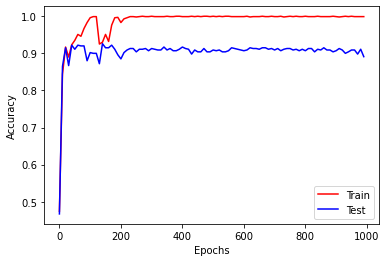

    Epoch  Acc_train  Acc_test  test_loss  train_loss
0     0.0      0.474     0.467      0.697       0.697
1    10.0      0.844     0.865      0.381       0.418
2    20.0      0.917     0.915      0.242       0.266
3    30.0      0.890     0.867      0.316       0.269
4    40.0      0.923     0.922      0.208       0.214
..    ...        ...       ...        ...         ...
95  950.0      1.000     0.909      6.098       0.000
96  960.0      0.999     0.909      5.850       0.000
97  970.0      0.999     0.898      5.943       0.001
98  980.0      0.999     0.911      5.920       0.001
99  990.0      0.999     0.891      5.566       0.000

[100 rows x 5 columns]


In [30]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_test,'b')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(Results)

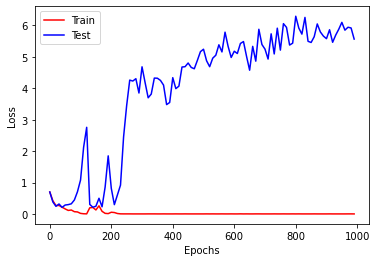

In [31]:
plt.plot(Results.Epoch,Results.train_loss,'r',Results.Epoch,Results.test_loss,'b')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [32]:
classes = ['No Voice', 'Voice']
y_pred = CNN(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       0.90      0.92      0.91       241
       Voice       0.91      0.88      0.90       219

    accuracy                           0.90       460
   macro avg       0.90      0.90      0.90       460
weighted avg       0.90      0.90      0.90       460



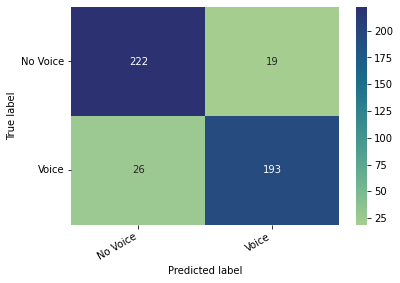

In [33]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
#hmap.color_palette("viridis", as_cmap=True)
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [34]:
y_pred = CNN(X_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       0.98      0.98      0.98      1256
       Voice       0.98      0.97      0.98      1044

    accuracy                           0.98      2300
   macro avg       0.98      0.98      0.98      2300
weighted avg       0.98      0.98      0.98      2300



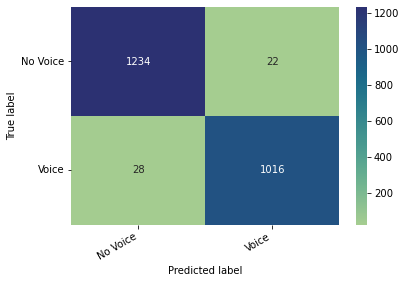

In [35]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [36]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
